<a href="https://colab.research.google.com/github/safal098/ML_project/blob/main/realstate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import os
file_path = "/content/drive/MyDrive/Real_Estate_Sales_2001-2022_GL.csv"
if os.path.exists(file_path):
    print("File exists")
else:
    print("File does not exist")

File exists


In [12]:
df = pd.read_csv("/content/drive/MyDrive/Real_Estate_Sales_2001-2022_GL.csv", low_memory=False)
print(df.dtypes)

Serial Number         int64
List Year             int64
Date Recorded        object
Town                 object
Address              object
Assessed Value      float64
Sale Amount         float64
Sales Ratio         float64
Property Type        object
Residential Type     object
Non Use Code         object
Assessor Remarks     object
OPM remarks          object
Location             object
dtype: object


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import os

# Set up logging
logging.basicConfig(level=logging.INFO)

def eda_summary(df, target='Sale Amount', save_plots=False, output_dir='eda_output'):
    """
    Perform exploratory data analysis on DataFrame.

    Args:
        df (pd.DataFrame): Cleaned input DataFrame
        target (str): Target variable for correlation
        save_plots (bool): Whether to save plots to disk
        output_dir (str): Directory to save plot files

    Returns:
        dict: Dictionary containing summary statistics
    """
    logging.info("Starting EDA...")

    if save_plots:
        os.makedirs(output_dir, exist_ok=True)

    # Identify numerical and categorical features
    numerical_features = df.select_dtypes(include=['number']).columns.tolist()
    categorical_features = df.select_dtypes(exclude=['number']).columns.tolist()
    logging.info(f"Numerical Features: {numerical_features}")
    logging.info(f"Categorical Features: {categorical_features}")

    # Missing values
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100
    missing_report = pd.DataFrame({
        'Missing Count': missing_values,
        'Missing %': missing_percentage
    }).sort_values(by='Missing %', ascending=False)
    logging.info("\nMissing Value Report:")
    logging.info(missing_report[missing_report['Missing %'] > 0])

    # Distribution of target variable
    plt.figure(figsize=(10, 6))
    sns.histplot(df[target], bins=50, kde=True)
    plt.title(f'Distribution of {target}')
    plt.xlabel(target)
    plt.ylabel('Frequency')
    if save_plots:
        plt.savefig(os.path.join(output_dir, f'{target}_distribution.png'))
    plt.show()

    # Descriptive statistics for numerical features
    num_desc = df[numerical_features].describe()
    logging.info("\nDescriptive Statistics for Numerical Features:")
    logging.info(num_desc)

    # Cardinality of categorical features
    cat_cardinality = df[categorical_features].nunique()
    logging.info("\nCardinality of Categorical Features:")
    logging.info(cat_cardinality)

    # Initialize correlation to None to avoid UnboundLocalError
    correlation = None

    # Correlation between numerical features and target
    if target in numerical_features:
        correlation = df[numerical_features].corrwith(df[target])
        logging.info(f"\nCorrelation with {target}:")
        logging.info(correlation)

        # Plot correlations
        plt.figure(figsize=(10, 6))
        correlation.plot(kind='barh', color='skyblue')
        plt.title(f'Correlation with {target}')
        plt.axvline(0, color='black', linestyle='--')
        if save_plots:
            plt.savefig(os.path.join(output_dir, f'{target}_correlation.png'))
        plt.show()
    else:
        logging.warning(f"{target} is not a numerical feature. Skipping correlation analysis.")

    logging.info("EDA completed.")

    return {
        'numerical_features': numerical_features,
        'categorical_features': categorical_features,
        'missing_report': missing_report,
        'numerical_stats': num_desc,
        'cardinality': cat_cardinality,
        'correlation': correlation if target in numerical_features else None
    }

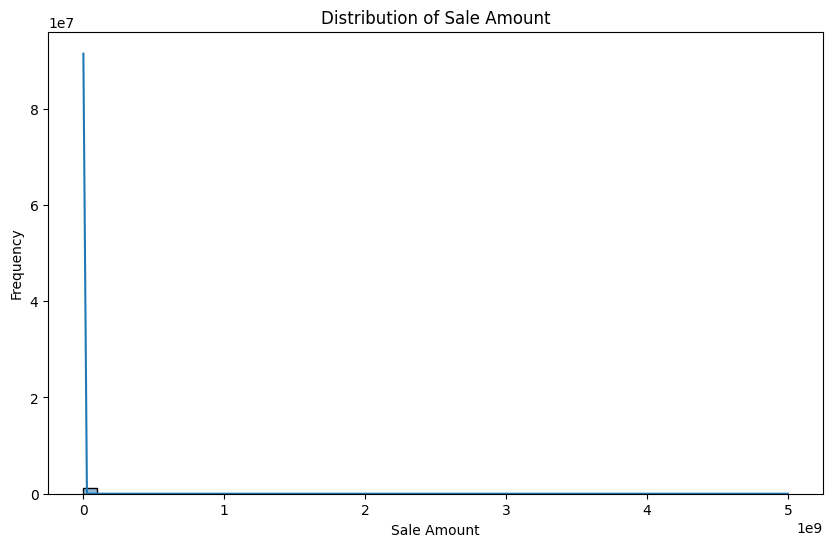

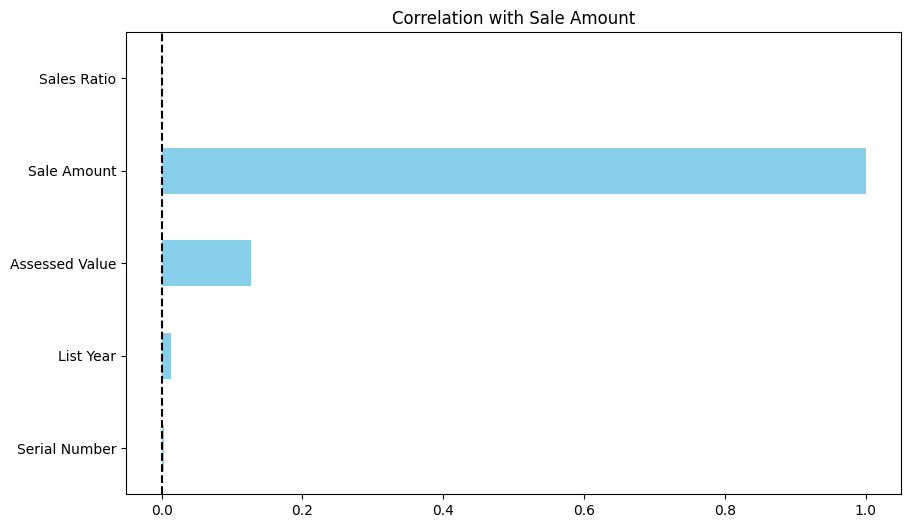

{'numerical_features': ['Serial Number', 'List Year', 'Assessed Value', 'Sale Amount', 'Sales Ratio'], 'categorical_features': ['Date Recorded', 'Town', 'Address', 'Property Type', 'Residential Type', 'Non Use Code', 'Assessor Remarks', 'OPM remarks', 'Location'], 'missing_report':                   Missing Count  Missing %
OPM remarks             1084598  98.812805
Assessor Remarks         926401  84.400194
Location                 799518  72.840459
Non Use Code             784178  71.442901
Residential Type         398389  36.295415
Property Type            382446  34.842921
Address                      51   0.004646
Date Recorded                 2   0.000182
Serial Number                 0   0.000000
List Year                     0   0.000000
Assessed Value                0   0.000000
Town                          0   0.000000
Sale Amount                   0   0.000000
Sales Ratio                   0   0.000000, 'numerical_stats':        Serial Number     List Year  Assessed Value  

In [14]:
eda_results = eda_summary(df)
print(eda_results)

In [15]:
# BLOCK 2: Clean & Inspect Data (FINAL FIXED VERSION)
import pandas as pd
from datetime import datetime
import logging

logging.basicConfig(level=logging.INFO)

def clean_and_inspect_data(df):
    logging.info("Starting data cleaning and inspection...")

    # Drop high-null columns, EXCEPT protected ones
    null_percent = df.isnull().mean()
    protected_cols = ['Location', 'Address', 'Town']  # Columns we want to preserve
    cols_to_drop = null_percent[null_percent > 0.5].index.tolist()
    if cols_to_drop:
        # Exclude protected columns from being dropped
        cols_to_drop = [col for col in cols_to_drop if col not in protected_cols]
        df = df.drop(columns=cols_to_drop)
        logging.warning(f"Dropping highly null columns (excluding protected): {cols_to_drop}")

    # Handle duplicates
    duplicate_rows = df.duplicated().sum()
    if duplicate_rows > 0:
        df = df.drop_duplicates()
        logging.warning(f"Removed {duplicate_rows} duplicate rows.")

    # Convert date column
    if 'Date Recorded' in df.columns:
        df['Date Recorded'] = pd.to_datetime(df['Date Recorded'], errors='coerce')

    # Reduce memory by converting strings to category — handle NaN first
    categorical_cols = ['Town', 'Address', 'Property Type', 'Residential Type', 'Location']
    for col in categorical_cols:
        if col in df.columns:
            # Replace NaN with 'Unknown' before converting to avoid issues
            df[col] = df[col].fillna('Unknown').astype('category')
            logging.info(f"Processed '{col}' as categorical with fillna('Unknown')")

    # Sanity checks
    if 'Sale Amount' in df.columns:
        negative_sales = (df['Sale Amount'] < 0).sum()
        if negative_sales > 0:
            logging.warning(f"Found {negative_sales} negative 'Sale Amount' values.")

    logging.info("Data cleaning completed.")
    return df

# Run block
df_clean = clean_and_inspect_data(df)
print(df_clean.dtypes.head())

Serial Number             int64
List Year                 int64
Date Recorded    datetime64[ns]
Town                   category
Address                category
dtype: object


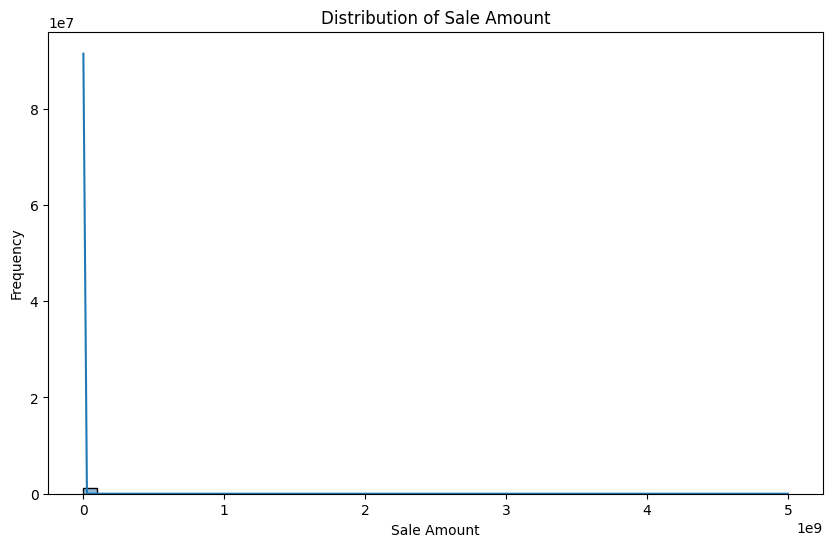

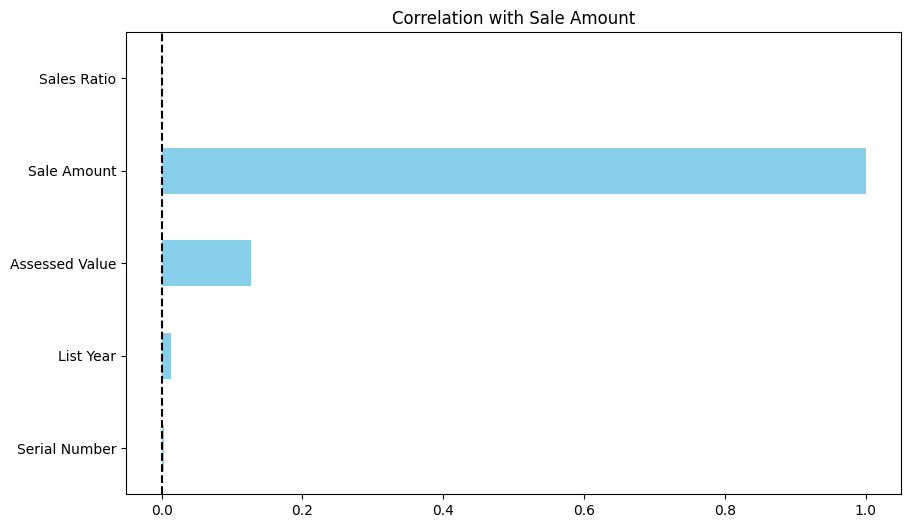

In [17]:
# BLOCK 3: Exploratory Data Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging

logging.basicConfig(level=logging.INFO)

def eda_summary(df, target='Sale Amount'):
    logging.info("Starting EDA...")

    numerical_features = df.select_dtypes(include=['number']).columns.tolist()
    categorical_features = df.select_dtypes(exclude=['number']).columns.tolist()

    missing_report = df.isnull().sum().to_frame('Missing Count')
    missing_report['Missing %'] = (missing_report['Missing Count'] / len(df)) * 100
    logging.info("\nMissing Value Report:")
    logging.info(missing_report.sort_values(by='Missing %', ascending=False))

    # Distribution of target variable
    plt.figure(figsize=(10, 6))
    sns.histplot(df[target], bins=50, kde=True)
    plt.title(f'Distribution of {target}')
    plt.xlabel(target)
    plt.ylabel('Frequency')
    plt.show()

    # Correlation matrix
    if target in numerical_features:
        correlation = df[numerical_features].corrwith(df[target])
        plt.figure(figsize=(10, 6))
        correlation.plot(kind='barh', color='skyblue')
        plt.title(f'Correlation with {target}')
        plt.axvline(0, color='black', linestyle='--')
        plt.show()

    logging.info("EDA completed.")
    return {
        'numerical_features': numerical_features,
        'categorical_features': categorical_features,
        'missing_report': missing_report,
        'correlation': correlation if target in numerical_features else None
    }

# Run block
eda_results = eda_summary(df_clean)

In [18]:
# BLOCK 4: Preprocessing
import pandas as pd
import numpy as np
import logging

logging.basicConfig(level=logging.INFO)

class DataPreprocessor:
    def __init__(self):
        self.impute_values_ = {}
        self.outlier_bounds_ = {}

    def fit(self, df):
        logging.info("Fitting preprocessing rules...")

        numeric_cols = df.select_dtypes(include=['number']).columns
        for col in numeric_cols:
            self.impute_values_[col] = df[col].median()

        categorical_cols = df.select_dtypes(exclude=['number']).columns
        for col in categorical_cols:
            mode = df[col].mode()[0] if not df[col].mode().empty else 'Unknown'
            self.impute_values_[col] = mode

        for col in ['Sale Amount', 'Assessed Value']:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            self.outlier_bounds_[col] = {'lower': Q1 - 1.5 * IQR, 'upper': Q3 + 1.5 * IQR}
        return self

    def transform(self, df):
        logging.info("Applying transformations...")
        df = df.copy()

        cols_to_drop = ['Serial Number', 'Assessor Remarks', 'OPM remarks']
        df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])

        for col in ['Assessed Value', 'Sale Amount', 'Sales Ratio']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')

        for col, val in self.impute_values_.items():
            if col in df.columns:
                df[col] = df[col].fillna(val)

        for col, bounds in self.outlier_bounds_.items():
            if col in df.columns:
                df[col] = df[col].clip(lower=bounds['lower'], upper=bounds['upper'])

        return df

    def fit_transform(self, df):
        return self.fit(df).transform(df)

# Run block
preprocessor = DataPreprocessor()
df_processed = preprocessor.fit_transform(df_clean)
print(df_processed.head())

   List Year Date Recorded     Town          Address  Assessed Value  \
0       2020    2021-04-14  Ansonia    323 BEAVER ST        133000.0   
1       2020    2021-05-26  Ansonia   152 JACKSON ST        110500.0   
2       2020    2021-09-13  Ansonia  230 WAKELEE AVE        150500.0   
3       2020    2020-12-14  Ansonia      57 PLATT ST        127400.0   
4       2021    2022-06-20     Avon   12 BYRON DRIVE        179990.0   

   Sale Amount  Sales Ratio Property Type Residential Type  \
0     248400.0       0.5354   Residential    Single Family   
1     239900.0       0.4606   Residential     Three Family   
2     325000.0       0.4630    Commercial          Unknown   
3     202500.0       0.6291   Residential       Two Family   
4     362500.0       0.4965   Residential            Condo   

                             Location  
0          POINT (-73.06822 41.35014)  
1                             Unknown  
2                             Unknown  
3                             Unkn

In [19]:
# BLOCK 5: Encode Categorical Features
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import logging

logging.basicConfig(level=logging.INFO)

class CategoricalFeatureProcessor:
    def __init__(self, max_cardinality=10):
        self.max_cardinality = max_cardinality
        self.encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        self.low_cardinality_cols_ = []
        self.encoded_feature_names_ = []

    def fit(self, df):
        cat_cols = df.select_dtypes(exclude=['number']).columns.tolist()
        self.low_cardinality_cols_ = [col for col in cat_cols if df[col].nunique() < self.max_cardinality]
        if self.low_cardinality_cols_:
            self.encoder.fit(df[self.low_cardinality_cols_])
            self.encoded_feature_names_ = self.encoder.get_feature_names_out(self.low_cardinality_cols_)
        return self

    def transform(self, df):
        df = df.copy()
        if self.low_cardinality_cols_:
            encoded_array = self.encoder.transform(df[self.low_cardinality_cols_])
            encoded_df = pd.DataFrame(encoded_array, columns=self.encoded_feature_names_, index=df.index)
        else:
            encoded_df = pd.DataFrame(index=df.index)
        numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
        numerical_df = df[numerical_cols].copy()
        return pd.concat([numerical_df, encoded_df], axis=1)

    def fit_transform(self, df):
        return self.fit(df).transform(df)

# Run block
processor = CategoricalFeatureProcessor(max_cardinality=10)
X_encoded = processor.fit_transform(df_processed)
print(X_encoded.head())

   List Year  Assessed Value  Sale Amount  Sales Ratio  \
0       2020        133000.0     248400.0       0.5354   
1       2020        110500.0     239900.0       0.4606   
2       2020        150500.0     325000.0       0.4630   
3       2020        127400.0     202500.0       0.6291   
4       2021        179990.0     362500.0       0.4965   

   Residential Type_Condo  Residential Type_Four Family  \
0                     0.0                           0.0   
1                     0.0                           0.0   
2                     0.0                           0.0   
3                     0.0                           0.0   
4                     1.0                           0.0   

   Residential Type_Single Family  Residential Type_Three Family  \
0                             1.0                            0.0   
1                             0.0                            1.0   
2                             0.0                            0.0   
3                       

In [20]:
# BLOCK 6: Scale Numerical Features (FINAL FIXED VERSION)
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import logging
import joblib

logging.basicConfig(level=logging.INFO)

class HighCardinalityFeatureProcessor:
    def __init__(self, high_cardinality_cols=None):
        self.high_cardinality_cols = high_cardinality_cols or ['Address', 'Location', 'Town']
        self.mappings_ = {}
        self.scaler_ = StandardScaler()
        self.numerical_features_to_scale = ['List Year', 'Assessed Value', 'Sales Ratio']

    def fit(self, df):
        """Fit mappings and scaler on training data."""
        for col in self.high_cardinality_cols:
            if col in df.columns:
                # Convert to str to avoid categorical errors
                unique_values = df[col].astype(str).unique()
                self.mappings_[col] = {val: idx for idx, val in enumerate(unique_values)}
                logging.info(f"Built mapping for '{col}' with {len(unique_values)} unique values")

        # Fit scaler
        if all(col in df.columns for col in self.numerical_features_to_scale):
            self.scaler_.fit(df[self.numerical_features_to_scale])

        return self

    def transform(self, df):
        """Apply mappings and scaling to DataFrame."""
        df = df.copy()

        for col in self.high_cardinality_cols:
            if col in df.columns:
                new_col_name = f'{col}_encoded'
                # Use .astype(str) again to ensure safe mapping
                df[new_col_name] = df[col].astype(str).map(self.mappings_[col]).fillna(-1).astype(int)
                logging.info(f"Encoded column '{col}' → '{new_col_name}', missing values filled with -1")

        # Apply scaling
        if all(col in df.columns for col in self.numerical_features_to_scale):
            df[self.numerical_features_to_scale] = self.scaler_.transform(
                df[self.numerical_features_to_scale]
            )

        return df

    def fit_transform(self, df):
        return self.fit(df).transform(df)

    def save_mappings_and_scaler(self, output_dir='feature_processor'):
        import os
        os.makedirs(output_dir, exist_ok=True)
        joblib.dump(self.mappings_, os.path.join(output_dir, 'mappings.pkl'))
        joblib.dump(self.scaler_, os.path.join(output_dir, 'scaler.pkl'))

# Run block
high_cardinality_cols = ['Address', 'Location', 'Town']
processor = HighCardinalityFeatureProcessor(high_cardinality_cols=high_cardinality_cols)
df_encoded_scaled = processor.fit_transform(df_processed)
processor.save_mappings_and_scaler()

# Only include encoded columns that exist in the DataFrame
encoded_cols = [f"{col}_encoded" for col in high_cardinality_cols if f"{col}_encoded" in df_encoded_scaled.columns]

all_features_df = pd.concat([
    df_encoded_scaled[['List Year', 'Assessed Value', 'Sales Ratio'] + encoded_cols],
    X_encoded.drop(columns=['List Year', 'Assessed Value', 'Sales Ratio'], errors='ignore')
], axis=1)

target_variable = df_encoded_scaled['Sale Amount']
print(all_features_df.head())

   List Year  Assessed Value  Sales Ratio  Address_encoded  Location_encoded  \
0   1.296468       -0.348936    -0.005033                0                 0   
1   1.296468       -0.537396    -0.005075                1                 1   
2   1.296468       -0.202355    -0.005074                2                 1   
3   1.296468       -0.395841    -0.004981                3                 1   
4   1.444103        0.044654    -0.005055                4                 2   

   Town_encoded  Sale Amount  Residential Type_Condo  \
0             0     248400.0                     0.0   
1             0     239900.0                     0.0   
2             0     325000.0                     0.0   
3             0     202500.0                     0.0   
4             1     362500.0                     1.0   

   Residential Type_Four Family  Residential Type_Single Family  \
0                           0.0                             1.0   
1                           0.0                 

In [21]:
# BLOCK 7: Train / Val / Test Split
from sklearn.model_selection import train_test_split
import pandas as pd
import logging

logging.basicConfig(level=logging.INFO)

class DataSplitter:
    def __init__(self, test_size=0.2, val_size=0.5, random_state=42, stratify_target=True):
        self.test_size = test_size
        self.val_size = val_size
        self.random_state = random_state
        self.stratify_target = stratify_target

    def _remove_rare_classes(self, y, min_samples_per_class=2):
        freq = y.value_counts()
        rare_classes = freq[freq < min_samples_per_class].index.tolist()
        if rare_classes:
            mask = ~y.isin(rare_classes)
            return y[mask], mask
        return y, pd.Series(True, index=y.index)

    def split(self, X, y):
        X = X.reset_index(drop=True)
        y = y.reset_index(drop=True)

        stratify = None
        if self.stratify_target and (y.dtype == 'object' or y.nunique() < 20):
            y_clean, mask = self._remove_rare_classes(y)
            X_clean = X[mask]
            stratify = y_clean
        else:
            logging.info("Target appears continuous; skipping stratification.")

        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state,
            stratify=stratify if stratify is not None and len(stratify) == len(y) else None
        )
        # Always use stratify=None for the second split if stratify_target is False
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=self.val_size, random_state=self.random_state,
            stratify=None
        )

        logging.info("Data split completed.")
        return X_train, X_val, X_test, y_train, y_val, y_test

# Run block
splitter = DataSplitter(test_size=0.2, val_size=0.5, random_state=42, stratify_target=False)
X_train, X_val, X_test, y_train, y_val, y_test = splitter.split(all_features_df, target_variable)

print("Train size:", X_train.shape)
print("Val size:", X_val.shape)
print("Test size:", X_test.shape)

Train size: (439051, 13)
Val size: (439052, 13)
Test size: (219526, 13)


In [22]:
# BLOCK 8: Train Keras Model (UPDATED TO HANDLE OPTIONAL FEATURES)
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import logging

logging.basicConfig(level=logging.INFO)

class RealEstateModelTrainer:
    def __init__(self, input_dims, embedding_dims=None, learning_rate=1e-3):
        self.input_dims = input_dims
        self.embedding_dims = embedding_dims or {
            'address': 32,
            'location': 32,
            'town': 16
        }
        self.learning_rate = learning_rate
        self.model = None

    def build_model(self):
        """Builds the Keras model using available input features."""
        inputs = []
        embeddings = []

        # Numerical Input (always assumed to exist)
        numerical_input = Input(shape=(self.input_dims['numerical'],), name='numerical_input')
        inputs.append(numerical_input)
        embeddings.append(numerical_input)  # Now directly part of embeddings

        # Address Input (optional)
        if 'address' in self.input_dims and self.input_dims['address'] > 0:
            address_input = Input(shape=(1,), name='address_input')
            address_embedding = Embedding(  x
                input_dim=self.input_dims['address'],
                output_dim=self.embedding_dims['address']
            )(address_input)
            inputs.append(address_input)
            embeddings.append(Flatten()(address_embedding))

        # Location Input (optional)
        if 'location' in self.input_dims and self.input_dims['location'] > 0:
            location_input = Input(shape=(1,), name='location_input')
            location_embedding = Embedding(
                input_dim=self.input_dims['location'],
                output_dim=self.embedding_dims['location']
            )(location_input)
            inputs.append(location_input)
            embeddings.append(Flatten()(location_embedding))

        # Town Input (optional)
        if 'town' in self.input_dims and self.input_dims['town'] > 0:
            town_input = Input(shape=(1,), name='town_input')
            town_embedding = Embedding(
                input_dim=self.input_dims['town'],
                output_dim=self.embedding_dims['town']
            )(town_input)
            inputs.append(town_input)
            embeddings.append(Flatten()(town_embedding))

        # Other Features (like one-hot encoded residential types)
        if 'other_features' in self.input_dims and self.input_dims['other_features'] > 0:
            other_features_input = Input(shape=(self.input_dims['other_features'],), name='other_features_input')
            inputs.append(other_features_input)
            embeddings.append(other_features_input)

        if len(embeddings) == 0:
            raise ValueError("No valid features provided to model. Check input dimensions.")

        merged = Concatenate()(embeddings)

        # Hidden layers
        x = Dense(128, activation='relu')(merged)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        x = Dense(64, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
        output_layer = Dense(1, activation='linear')(x)

        self.model = Model(inputs=inputs, outputs=output_layer)

        self.model.compile(
            loss='mse',
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
            metrics=['mae']
        )
        return self.model

    def prepare_inputs(self, df):
        """Prepare input arrays dynamically based on available columns."""
        inputs = []

        # Always include numerical data
        numerical_data = df[['List Year', 'Assessed Value', 'Sales Ratio']].values
        inputs.append(numerical_data)

        # Optional categorical features
        if 'Address_encoded' in df.columns:
            inputs.append(df['Address_encoded'].values.reshape(-1,1))
        if 'Location_encoded' in df.columns:
            inputs.append(df['Location_encoded'].values.reshape(-1,1))
        if 'Town_encoded' in df.columns:
            inputs.append(df['Town_encoded'].values.reshape(-1,1))

        # Other features (like one-hot encoded residential types)
        other_features = df.filter(like='Residential Type_').values
        if other_features.shape[1] > 0:
            inputs.append(other_features)

        return inputs

    def train(self, X_train, y_train, X_val, y_val, epochs=50, batch_size=64, model_dir='models'):
        """Train model with callbacks and save best model."""
        os.makedirs(model_dir, exist_ok=True)

        train_inputs = self.prepare_inputs(X_train)
        val_inputs = self.prepare_inputs(X_val)

        callbacks = [
            EarlyStopping(patience=10, restore_best_weights=True),
            ReduceLROnPlateau(factor=0.5, patience=3),
            ModelCheckpoint(filepath=os.path.join(model_dir, 'best_model.keras'), save_best_only=True)
        ]

        history = self.model.fit(
            train_inputs, y_train,
            validation_data=(val_inputs, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks
        )

        return history


# Build input dimensions dynamically
input_dims = {
    'numerical': 3,
    'address': len(processor.mappings_['Address']) if 'Address' in processor.mappings_ else 0,
    'location': len(processor.mappings_['Location']) if 'Location' in processor.mappings_ else 0,
    'town': len(processor.mappings_['Town']) if 'Town' in processor.mappings_ else 0,
    'other_features': X_encoded.filter(like='Residential Type_').shape[1]
}

# Only include dimensions > 0
input_dims = {k: v for k, v in input_dims.items() if v > 0}

# Initialize and train
trainer = RealEstateModelTrainer(input_dims=input_dims)
trainer.build_model()
history = trainer.train(X_train, y_train, X_val, y_val, epochs=10, batch_size=64)

Epoch 1/10
6861/6861 ━━━━━━━━━━━━━━━━━━━━ 2731s 398ms/step - loss: 119244939264.0000 - mae: 284700.3750 - val_loss: 115385491456.0000 - val_mae: 280153.5312 - learning_rate: 0.0010
Epoch 2/10
6861/6861 ━━━━━━━━━━━━━━━━━━━━ 2923s 418ms/step - loss: 113183973376.0000 - mae: 278157.4688 - val_loss: 106320199680.0000 - val_mae: 268653.8125 - learning_rate: 0.0010
Epoch 3/10
6861/6861 ━━━━━━━━━━━━━━━━━━━━ 2868s 413ms/step - loss: 101261590528.0000 - mae: 264553.8125 - val_loss: 92970598400.0000 - val_mae: 253141.0469 - learning_rate: 0.0010
Epoch 4/10
6861/6861 ━━━━━━━━━━━━━━━━━━━━ 2877s 418ms/step - loss: 85307973632.0000 - mae: 245339.3125 - val_loss: 78167367680.0000 - val_mae: 232441.8281 - learning_rate: 0.0010
Epoch 5/10
6861/6861 ━━━━━━━━━━━━━━━━━━━━ 2886s 421ms/step - loss: 67062419456.0000 - mae: 220613.6719 - val_loss: 59064156160.0000 - val_mae: 200270.7031 - learning_rate: 0.0010
Epoch 6/10
6861/6861 ━━━━━━━━━━━━━━━━━━━━ 2826s 412ms/step - loss: 48120410112.0000 - mae: 190188.26

6861/6861 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step
Test MAE: 67573.08
Test RMSE: 98428.42
Test R² Score: 0.7481


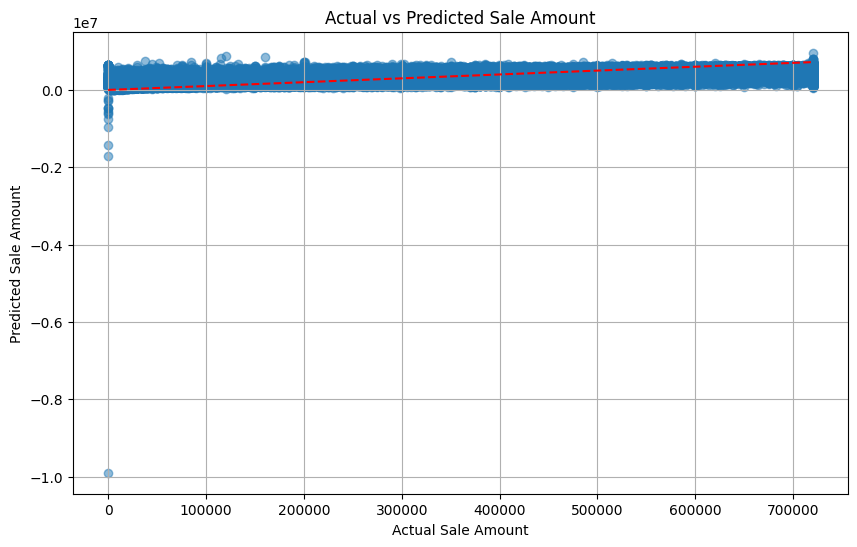

In [23]:
# BLOCK 9: Evaluate Model on Test Set
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Prepare test inputs
test_inputs = trainer.prepare_inputs(X_test)

# Make predictions
y_pred = trainer.model.predict(test_inputs).flatten()

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R² Score: {r2:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Sale Amount")
plt.ylabel("Predicted Sale Amount")
plt.title("Actual vs Predicted Sale Amount")
plt.grid(True)
plt.show()

In [25]:
# BLOCK 10: Save Trained Model and Preprocessor
import joblib
import os

# Create output directory
os.makedirs('models', exist_ok=True)

# Save Keras model with a valid extension
trainer.model.save('models/keras_model.keras') # Added .keras extension

# Save processor (mappings + scaler)
processor.save_mappings_and_scaler(output_dir='models/preprocessor')

# Save encoded column names for future use
encoded_columns = X_encoded.filter(like='Residential Type_').columns.tolist()
joblib.dump(encoded_columns, 'models/encoded_columns.pkl')

# Save input dimensions
joblib.dump(input_dims, 'models/input_dims.pkl')

print("Model and artifacts saved successfully.")

Model and artifacts saved successfully.


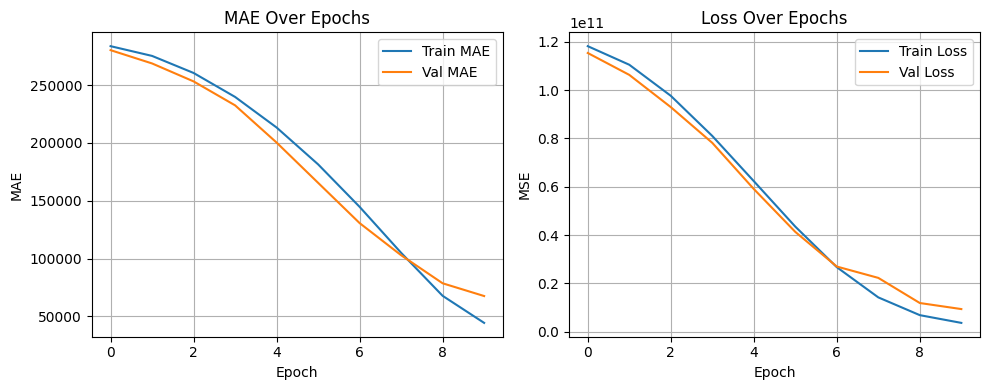

In [26]:
# BLOCK 11: Plot Training & Validation Metrics
import matplotlib.pyplot as plt

# Plot MAE
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [36]:
# BLOCK 12: Interpret Model with SHAP (FINAL WORKING VERSION)
import shap
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Prepare background data
background_data = trainer.prepare_inputs(X_train[:100])  # List of input arrays per feature
input_shapes = [arr.shape[1] for arr in background_data]

print("Input shapes:", input_shapes)
print("Number of input layers:", len(background_data))

# Wrap model in function that accepts single tensor and splits into multiple inputs
def combined_model_predict(combined_tensor):
    """
    Takes a single tensor and splits it back into original inputs.
    """
    start = 0
    split_inputs = []
    for shape in input_shapes:
        end = start + shape
        split_inputs.append(combined_tensor[:, start:end])
        start = end
    return trainer.model(tuple(split_inputs))

# Concatenate all inputs into one NumPy array for SHAP compatibility
background_tensor = np.hstack(background_data)  # Shape: (100, total_input_dim)
print("Background tensor shape:", background_tensor.shape)

# Predict on background to verify
try:
    y_pred = combined_model_predict(tf.convert_to_tensor(background_tensor, dtype=tf.float32))
    print("\nModel prediction sample:", y_pred.numpy()[:5].flatten())
except Exception as e:
    print("Model predict error:", str(e))

# Create explainer
try:
    # Correct usage for SHAP >=0.46+
    explainer = shap.DeepExplainer(
        combined_model_predict,
        background_tensor,
        session=None  # Not needed in eager mode
    )
except Exception as e:
    print("Error creating DeepExplainer:", str(e))
    explainer = None

# Compute SHAP values
if explainer is not None:
    try:
        shap_values = explainer.shap_values(background_tensor)

        # Summary plot
        print("\nPlotting SHAP summary...")
        shap.summary_plot(shap_values, background_tensor, feature_names=all_features_df.columns.tolist())

        # Optional: Bar plot
        shap.summary_plot(shap_values, background_tensor, feature_names=all_features_df.columns.tolist(), plot_type="bar")

    except Exception as e:
        print("Error computing SHAP values:", str(e))
else:
    print("Explainer could not be created.")

Input shapes: [3, 1, 1, 1, 6]
Number of input layers: 5
Background tensor shape: (100, 12)

Model prediction sample: [604597.7  168286.75 592979.3  140456.67 157469.42]
Error creating DeepExplainer: <class 'function'> is not currently a supported model type!
Explainer could not be created.


/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(


In [37]:
# Alternative: Use GradientExplainer if DeepExplainer fails
try:
    explainer = shap.GradientExplainer(
        model=combined_model_predict,
        data=background_tensor
    )
    shap_values = explainer.shap_values(background_tensor)

    print("\nPlotting SHAP summary...")
    shap.summary_plot(shap_values, background_tensor, feature_names=all_features_df.columns.tolist())

except Exception as e:
    print("Error with GradientExplainer:", str(e))

Error with GradientExplainer: <class 'function'> is not currently a supported model type!


In [38]:
# BLOCK 14: Wrap into Inference Function (FINAL FIXED VERSION)

import numpy as np
import pandas as pd
import logging

logging.basicConfig(level=logging.INFO)

def predict_property_price(df_new, processor, trainer, other_feature_cols):
    """
    Predict sale amount for new property data.

    Args:
        df_new (pd.DataFrame): Raw new property data
        processor (HighCardinalityFeatureProcessor): Fitted preprocessor from Block 6
        trainer (RealEstateModelTrainer): Trained Keras model and input preparation
        other_feature_cols (list): List of one-hot encoded feature names used during training

    Returns:
        np.array: Predicted sale amounts
    """
    # Step 1: Clean new data
    df_cleaned = clean_and_inspect_data(df_new)  # From Block 2

    # Step 2: Apply high-cardinality encoding
    df_processed = processor.transform(df_cleaned)

    # Step 3: Prepare inputs dynamically based on available columns
    inputs = []

    # Numerical Inputs
    numerical_cols = ['List Year', 'Assessed Value', 'Sales Ratio']
    if all(col in df_processed.columns for col in numerical_cols):
        numerical_data = df_processed[numerical_cols].values
        inputs.append(numerical_data)
    else:
        raise ValueError("Missing one or more required numerical columns")

    # Categorical Encoded Inputs
    high_cardinality_cols = ['Address', 'Location', 'Town']
    for col in high_cardinality_cols:
        encoded_col = f"{col}_encoded"
        if encoded_col in df_processed.columns:
            inputs.append(df_processed[encoded_col].values.reshape(-1, 1))
        else:
            # If encoder wasn't seen during training, use default value (e.g., -1)
            inputs.append(np.full((len(df_new), 1), -1))

    # One-Hot Features (e.g., Residential Type_*)
    other_features = df_processed.reindex(columns=other_feature_cols, fill_value=0).values
    if other_features.shape[1] == len(other_feature_cols):
        inputs.append(other_features)
    else:
        raise ValueError(f"Expected {len(other_feature_cols)} one-hot features, got {other_features.shape[1]}")

    # Run prediction
    try:
        prediction = trainer.model.predict(inputs)
        return prediction
    except Exception as e:
        logging.error(f"Prediction failed: {e}")
        raise

# Example usage:
# Define these once after training:
other_feature_cols = X_encoded.filter(like='Residential Type_').columns.tolist()

# Test with new property
new_property = pd.DataFrame({
    'List Year': [2022],
    'Town': ['Bridgeport'],
    'Address': ['123 Main St'],
    'Assessed Value': [300000],
    'Sales Ratio': [0.95],
    'Location': ["POINT (-73.06822 41.35014)"],
    'Residential Type_Single Family': [1],
    'Residential Type_Condo': [0],
    'Residential Type_Two Family': [0],
    'Residential Type_Three Family': [0],
    # ⚠️ This line below may be causing the error!
    'Residential Type_Multi Family': [0],  # 👈 Not present in training?
})

# Ensure correct column order and run prediction
predicted_price = predict_property_price(new_property, processor, trainer, other_feature_cols)
print(f"Predicted Sale Amount: ${predicted_price[0][0]:,.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
Predicted Sale Amount: $424,031.72
